# Homework 4: Variational Inference
- Name: Congxin (David) Xu
- Computing ID: cx2rx

### Honor Pledge: 
I have neither given nor received aid on this assignment.

### Problem 1
(20) Use the EM implementation for Gaussian mixture models (GMM) in sklearn to segment the image Haiti Image.tif into four classes. Then answer the following questions.
- Compare the classification results obtained with the GMM to those obtained from K-means (KM) segmentation of the same image. Again use four classes for KM. Show the results of the two approaches to segmentation as images with the separate classes shown in different colors. Comment on the similarities and differences in the two segmentations
- Write the equation for the posterior prediction of the probability of the class label for each data points in the image.
- Show four separate images, one for each class, that color code the probabilities of a class label for each data point in the image. Comment on the insights provided by this probabilistic view of the segmentation. Very briefly describe example of how this probabilistic perspective might be used by governmental or non-profit agencies concerned with improving the environment or the living conditions in Haiti.

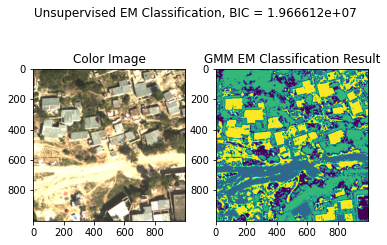

In [1]:
# Unsupervised Image Classification
# using Gaussian Mixture Model Expectation Maximization

from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# read the image and convert to numpy array
im = Image.open('Haiti_Image.tif')
imArray = np.array(im)
nrows, ncols, nbands = np.shape(imArray)

# reshape the image array to num_observations by num_features (1,000,000 by 3)
# put that into the EM algorithm in a way that EM can understand
# in the segmentation 
# Each row will be a pixel that have 3 values with RGB values
X = np.reshape(imArray,[nrows*ncols,nbands])

# Call and train the Gaussian Mixture
# tolarence: tolds when to stop the process
# how close the log likelihood to be when to stop
model = GaussianMixture(n_components=4, tol=0.0001)
model.fit(X)
# Find the hard classes based on the maximum probability of N classes
yhat = model.predict(X)

pred_probs = model.predict_proba(X)

# reshape the result into an image
imSubset_hat = np.reshape(yhat,[nrows,ncols])

# plot the output, including the BIC in the title
plt.figure()
plt.suptitle('Unsupervised EM Classification, BIC = '+"{:e}".format(model.bic(X)))
plt.subplot(121)
plt.imshow(imArray)
plt.title('Color Image')
plt.subplot(122)
plt.imshow(imSubset_hat)
plt.title('GMM EM Classification Result')
plt.show()

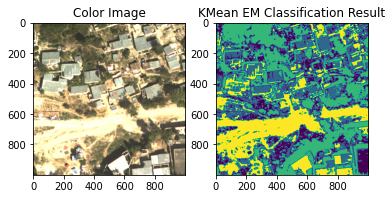

In [2]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

yhat = kmeans.predict(X)

imSubset_hat = np.reshape(yhat,[nrows,ncols])

# plot the output, including the BIC in the title
plt.figure()
plt.subplot(121)
plt.imshow(imArray)
plt.title('Color Image')
plt.subplot(122)
plt.imshow(imSubset_hat)
plt.title('KMean EM Classification Result')
plt.show()

Both GMM and K-means model have 4 classes and both methods classify out the buildings, trees, roads and others. However, within the GMM model, almost all the buildings appears to have the same cluster membership, but the KMeans model separated the buildings into two different categories.

The equation for the posterior prediction of the probability of the class label for each data points in the image is 

$$p(x|\theta) = \sum_{k = 1}^K p(x|\theta, k) p(k)$$

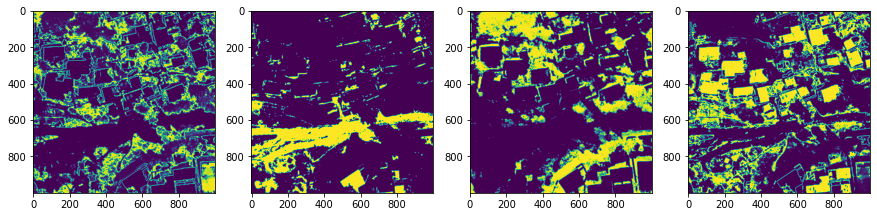

In [3]:
# get posterior probabilities
probs = model.predict_proba(X)
plt.figure(figsize=(15,5))

# Create a list to store the image pixels
c = list()

# Generate a plot for each class
for i in range(0, 4):
    c.append(np.reshape(probs[:,i], [nrows,ncols]))
    plt.subplot(141+i)
    plt.imshow(c[i])    

- Class 1 looks like a class of the trees or vegetation. 
- Class 2 looks like a class of main roads
- Class 3 looks like a class of walking area
- Class 4 looks like buildings

One example is that we can monitor the class of trees or vegetation over time and study the change of member for this class to see whether there is an environment improvement over the years.


### Problem 2
Explain how the Evidential Lower Bound (ELBO) has components
that trade-off between bias and variance.

### Problem 3
(20) Provide displays that illustrate variational approximation for the following two examples.

- Suppose we have a two dimensional Gaussian with an arbitrary mean, $\mu$, and with a variance-covariance matrix with $\sigma_{11} = 1.0$, $\sigma_{22} = \sqrt{0.5}$, and the correlation, $\rho = 0.75$ Show the variational approximation that minimizes the Kullback-Liebler divergence with this Gaussian using the mean field assumption. Explain the shape of this approximation.
- Suppose we have the following results from tests of infections in the sore throats of our patients: $\{0, 1, 0,  1, 1,  0, 0, 0, 0, 0\}$, where 1 indicates an infection and 0 indicates no infection. We assume a uniform prior for the probability of infection. Show the plot of the true posterior and use the ADVI optimization to obtain the variational approximation of the posterior. Overlay the plot of this approximation on the true posterior.
- (+3 extra credit) Show the Laplace approximation of the posterior and briefly comment on the visible differences with the variational approximation.

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.distributions import draw_values
from pymc3.distributions.dist_math import bound
from pymc3.math import logsumexp
import scipy as sp
import scipy.stats as st
import seaborn as sns
from theano import shared, tensor as tt

SEED = 12345 
np.random.seed(SEED)

SIGMA_theta1 = 1
SIGMA_theta2 = np.sqrt(0.5)
CORR_COEF = 0.75

true_cov = np.array([[SIGMA_theta1**2, CORR_COEF * SIGMA_theta1 * SIGMA_theta2],
                     [CORR_COEF * SIGMA_theta1 * SIGMA_theta2, SIGMA_theta2**2]])

true_precision = np.linalg.inv(true_cov)

approx_sigma_theta1, approx_sigma_theta2 = 1. / np.sqrt(np.diag(true_precision))

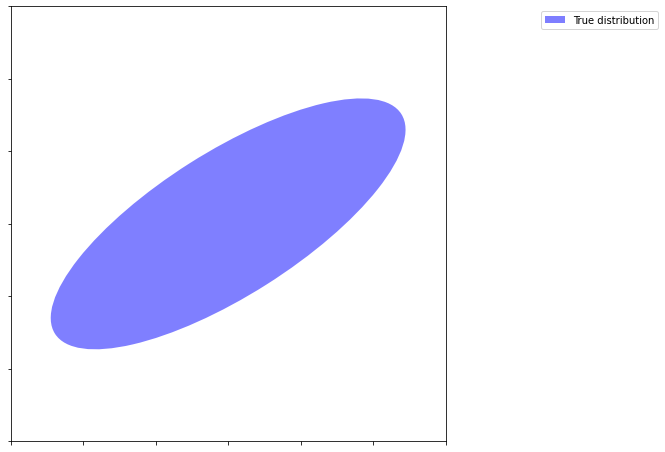

In [5]:
fig, ax  = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal');


var, U = np.linalg.eig(true_cov)
angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))

e = Ellipse(np.zeros(2), 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle)
e.set_alpha(0.5)
e.set_facecolor('blue')
e.set_zorder(10);
ax.add_artist(e);

ax.set_xlim(-3, 3);
ax.set_xticklabels([]);

ax.set_ylim(-3, 3);
ax.set_yticklabels([]);

rect = plt.Rectangle((0, 0), 1, 1, fc='blue', alpha=0.5)
ax.legend([rect],
          ['True distribution'],
          bbox_to_anchor=(1.5, 1.));

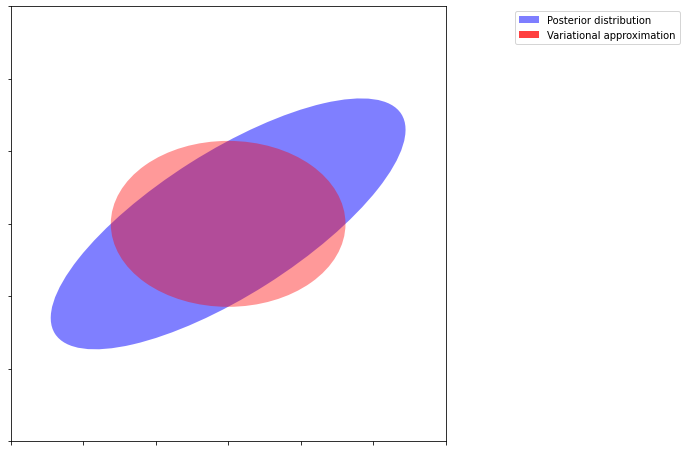

In [6]:
# Find the appoximating Gaussian with uncorrelated variables

vi_e = Ellipse(np.zeros(2), 2 * np.sqrt(5.991) * approx_sigma_theta1, 
               2 * np.sqrt(5.991) * approx_sigma_theta2)
vi_e.set_alpha(0.4)
vi_e.set_facecolor('red')
vi_e.set_zorder(11);
ax.add_artist(vi_e);

vi_rect = plt.Rectangle((0, 0), 1, 1, fc='red', alpha=0.75)

ax.legend([rect, vi_rect],
          ['Posterior distribution',
           'Variational approximation'],
          bbox_to_anchor=(1.55, 1.));
fig

Under the mean field assumption, the approximation is going to parittion the elements of the bivariate Gaussain model into 2 disjoint groups and we seek the one which has the largest lower bound of each group. We can see the mean of the variational approximiation and the mean of the true posterior distribuion are located in the same place. The variance of the variational approximation will be determined by the largest lower bound of each group.

In [7]:
# Input Data
x_beta_binomial = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])
# Create the model
with pm.Model() as beta_binomial_model:
    p_beta_binomial = pm.Uniform('p', 0., 1.)
    x_obs = pm.Bernoulli('x', p_beta_binomial,
                         observed=x_beta_binomial)

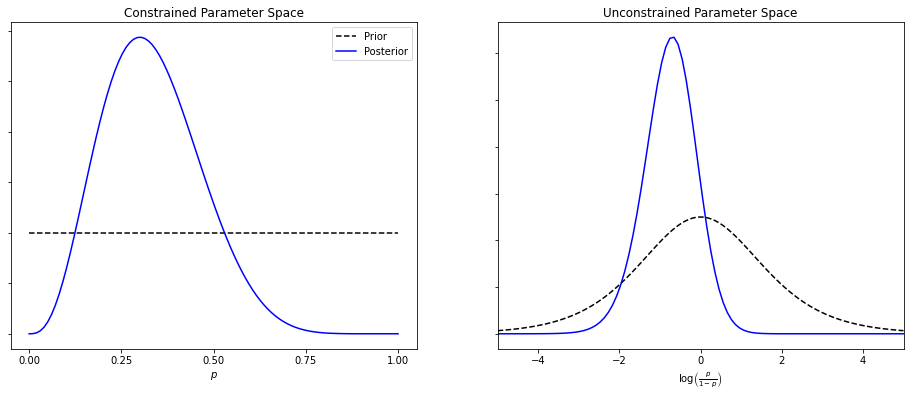

In [8]:
# plot the transformed (unconstrained) parameters
fig, (const_ax, trans_ax) = plt.subplots(ncols=2, figsize=(16, 6))

prior = sp.stats.uniform(0, 1)
posterior = sp.stats.beta(1 + x_beta_binomial.sum(),
                          1 + (1 - x_beta_binomial).sum())

# constrained distribution plots
const_x = np.linspace(0, 1, 100)
const_ax.plot(const_x, prior.pdf(const_x),
              '--', c='k', label='Prior');

def logit_trans_pdf(pdf, x):
    x_logit = sp.special.logit(x)
    return pdf(x_logit) / (x * (1 - x))

const_ax.plot(const_x, posterior.pdf(const_x),
              c='blue', label='Posterior');

const_ax.set_xticks(np.linspace(0, 1, 5));
const_ax.set_xlabel(r'$p$');
const_ax.set_yticklabels([]);
const_ax.set_title('Constrained Parameter Space');
const_ax.legend(loc=1);

# unconstrained distribution plots
def expit_trans_pdf(pdf, x):
    x_expit = sp.special.expit(x)
    return pdf(x_expit) * x_expit * (1 - x_expit)

trans_x = np.linspace(-5, 5, 100)
trans_ax.plot(trans_x, expit_trans_pdf(prior.pdf, trans_x),
              '--', c='k');
trans_ax.plot(trans_x, expit_trans_pdf(posterior.pdf, trans_x),
              c='blue');

trans_ax.set_xlim(trans_x.min(), trans_x.max());
trans_ax.set_xlabel(r'$\log\left(\frac{p}{1 - p}\right)$');
trans_ax.set_yticklabels([]);
trans_ax.set_title('Unconstrained Parameter Space');

In [9]:
# Obtain the variational approximation to the beta

with beta_binomial_model:
    approx = pm.fit(50000, method = 'advi', random_seed = SEED)

Finished [100%]: Average Loss = 7.1941


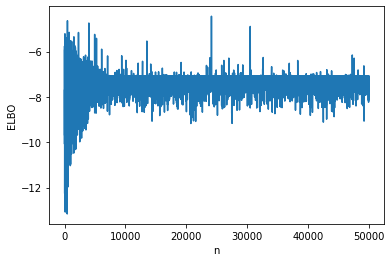

In [10]:
advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

# Can also use - 
# plt.plot(approx.hist);

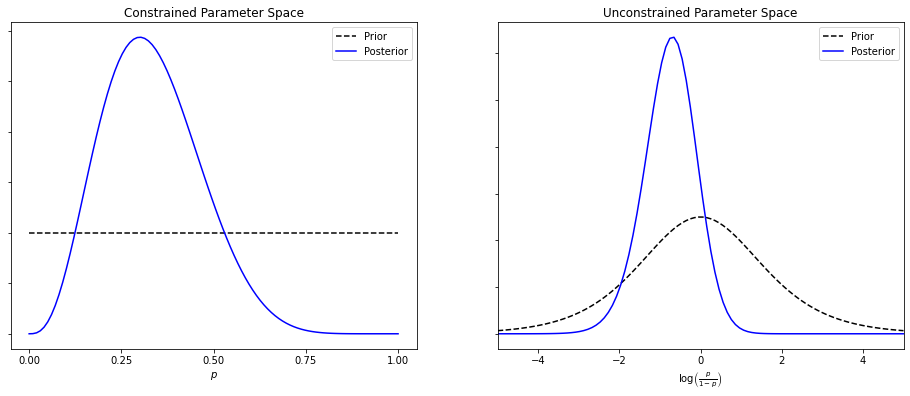

In [11]:
# The approximation parameters

advi_bb_mu = approx.mean.eval()
advi_bb_std = approx.std.eval()
advi_bb_dist = sp.stats.norm(advi_bb_mu, advi_bb_std)

# plot the transformed (unconstrained) parameters
fig, (const_ax, trans_ax) = plt.subplots(ncols=2, figsize=(16, 6))

prior = sp.stats.uniform(0, 1)
posterior = sp.stats.beta(1 + x_beta_binomial.sum(),
                          1 + (1 - x_beta_binomial).sum())

# constrained distribution plots
const_x = np.linspace(0, 1, 100)
const_ax.plot(const_x, prior.pdf(const_x),
              '--', c='k', label='Prior');

def logit_trans_pdf(pdf, x):
    x_logit = sp.special.logit(x)
    return pdf(x_logit) / (x * (1 - x))

const_ax.plot(const_x, posterior.pdf(const_x),
              c='blue', label='Posterior');

const_ax.set_xticks(np.linspace(0, 1, 5));
const_ax.set_xlabel(r'$p$');
const_ax.set_yticklabels([]);
const_ax.set_title('Constrained Parameter Space');
const_ax.legend(loc=1);

# unconstrained distribution plots
def expit_trans_pdf(pdf, x):
    x_expit = sp.special.expit(x)
    return pdf(x_expit) * x_expit * (1 - x_expit)

trans_x = np.linspace(-5, 5, 100)
trans_ax.plot(trans_x, expit_trans_pdf(prior.pdf, trans_x),
              '--', c='k', label = "Prior");
trans_ax.plot(trans_x, expit_trans_pdf(posterior.pdf, trans_x),
              c='blue', label = "Posterior");

trans_ax.set_xlim(trans_x.min(), trans_x.max());
trans_ax.set_xlabel(r'$\log\left(\frac{p}{1 - p}\right)$');
trans_ax.set_yticklabels([]);
trans_ax.set_title('Unconstrained Parameter Space');
trans_ax.legend(loc=1);

# plot the ADVI gaussian approximation to the unconstrained posterior
#trans_ax.plot(trans_x, advi_bb_dist.pdf(trans_x),
#              c='red', label='Variational approximation');
#fig

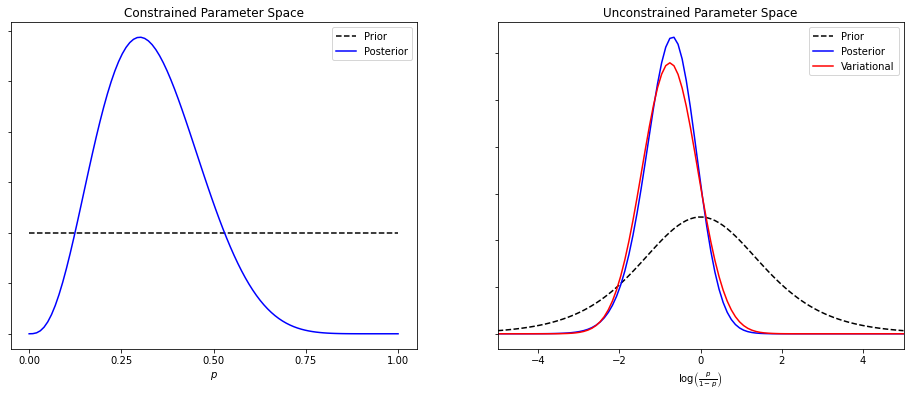

In [12]:
# plot the ADVI gaussian approximation to the unconstrained posterior
trans_ax.plot(trans_x, advi_bb_dist.pdf(trans_x),
              c='red', label='Variational');
trans_ax.legend(loc=1);

fig

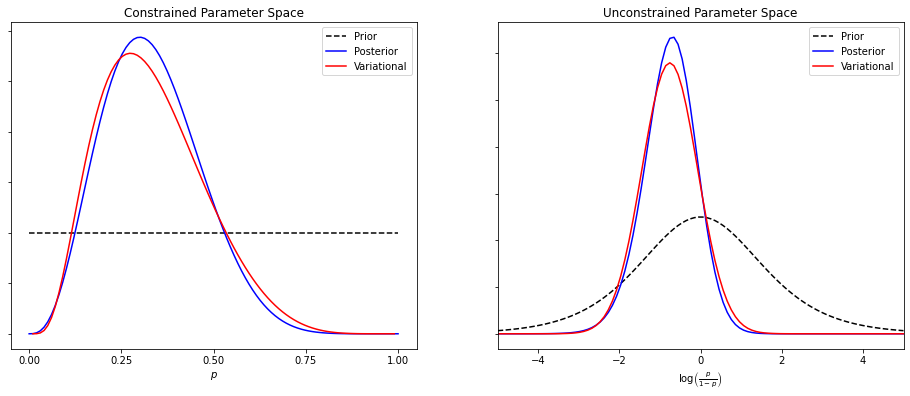

In [13]:
# plot the ADVI approximation to the true posterior
const_ax.plot(const_x, logit_trans_pdf(advi_bb_dist.pdf, const_x),
              c='red', label='Variational');
const_ax.legend(loc = 1)
fig

### Problem 4

(20) With the CHD data set (CHDdata.csv) from the previous two homework assignments develop a variational inference estimate using ADVI
optimization for the posterior distributions of the parameters in a main
effects logistic regression model. Use all predictor variables in the data set
and standardize all of the numeric, continuous predictors using the mean
and standard deviation. For each of the parameters in the regression, use a
Gaussian prior with a mean vector of 0 and the identity matrix as the
variance-covariance matrix. Show the ELBO plot from the optimization and discuss how it looks. Use plots to discuss and compare the marginals
for each of the regression model parameters obtained from variational inference with that obtained from sampling with Hamiltonian MC.


In [14]:
data = pd.read_csv('CHDdata.csv')
data.head()

sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11  Present     49    25.30    97.20   52    1
1  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63    1
2  118     0.08  3.48      32.28  Present     52    29.14     3.81   46    0
3  170     7.50  6.41      38.03  Present     51    31.99    24.26   58    1
4  134    13.60  3.50      27.78  Present     60    25.99    57.34   49    1

In [15]:
# Standardize all numeric variables
tmp = data[['famhist']].astype('category')
tmp["famhist"] = tmp["famhist"].cat.codes.values
tmp2 = data[['chd']]

data = data.drop('famhist', axis = 1)
data = data.drop('chd', axis = 1)

normalized_data=(data-data.mean())/data.std()
normalized_data = pd.concat([tmp,  
                             normalized_data.reset_index(drop=True),], 
                            axis=1)

normalized_data = pd.concat([tmp2,  
                             normalized_data.reset_index(drop=True),], 
                            axis=1)
practitioner_idx = normalized_data.famhist.astype('category').cat.codes.values
normalized_data.head()

chd  famhist       sbp   tobacco       ldl  adiposity     typea   obesity  \
0    1        1  1.057417  1.821099  0.477894  -0.295183 -0.418017 -0.176594   
1    1        0  0.276789 -0.789382 -0.159507   0.411694  0.193134  0.670646   
2    0        1 -0.991731 -0.774141 -0.608585   0.883374 -0.112441  0.734723   
3    1        1  1.545310  0.841352  0.806252   1.622382 -0.214300  1.411091   
4    1        1 -0.211103  2.169453 -0.598928   0.305020  0.702427 -0.012842   

    alcohol       age  
0  3.274189  0.628654  
1 -0.612081  1.381617  
2 -0.540597  0.217947  
3  0.294742  1.039361  
4  1.645991  0.423301

In [16]:
# Original Model
with pm.Model() as logistic_model_all:
    Y = normalized_data['chd']
    pm.glm.GLM.from_formula('Y ~ famhist+sbp+tobacco+ldl+adiposity+typea+obesity+alcohol+age',
                            data = normalized_data, family = pm.glm.families.Binomial())
    trace_hw3 = pm.sample(1000, tune = 1000, init = 'adapt_diag', cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [age, alcohol, obesity, typea, adiposity, ldl, tobacco, sbp, famhist, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [17]:

with pm.Model() as advi_var_inf:
    Y = normalized_data['chd']
    pm.glm.GLM.from_formula('Y ~ famhist+sbp+tobacco+ldl+adiposity+typea+obesity+alcohol+age',
                            data = normalized_data, family = pm.glm.families.Binomial())
    trace_hw4 = pm.fit(40000, method = 'advi', random_seed = 666)

Finished [100%]: Average Loss = 318.65


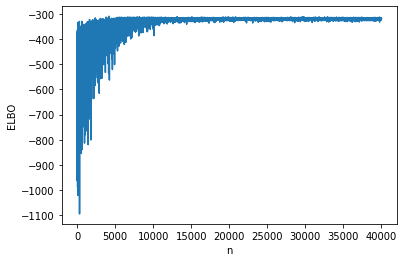

In [18]:
advi_elbo = pd.DataFrame(
    {'ELBO': -trace_hw4.hist,
     'n': np.arange(trace_hw4.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [19]:
# sample from the variational posterior distribution
PPC_SAMPLES = 4000
advi_trace = trace_hw4.sample(PPC_SAMPLES)

Based on the ELBO plot above, we can see that our variation approximation converges after about 15000 iteration. 

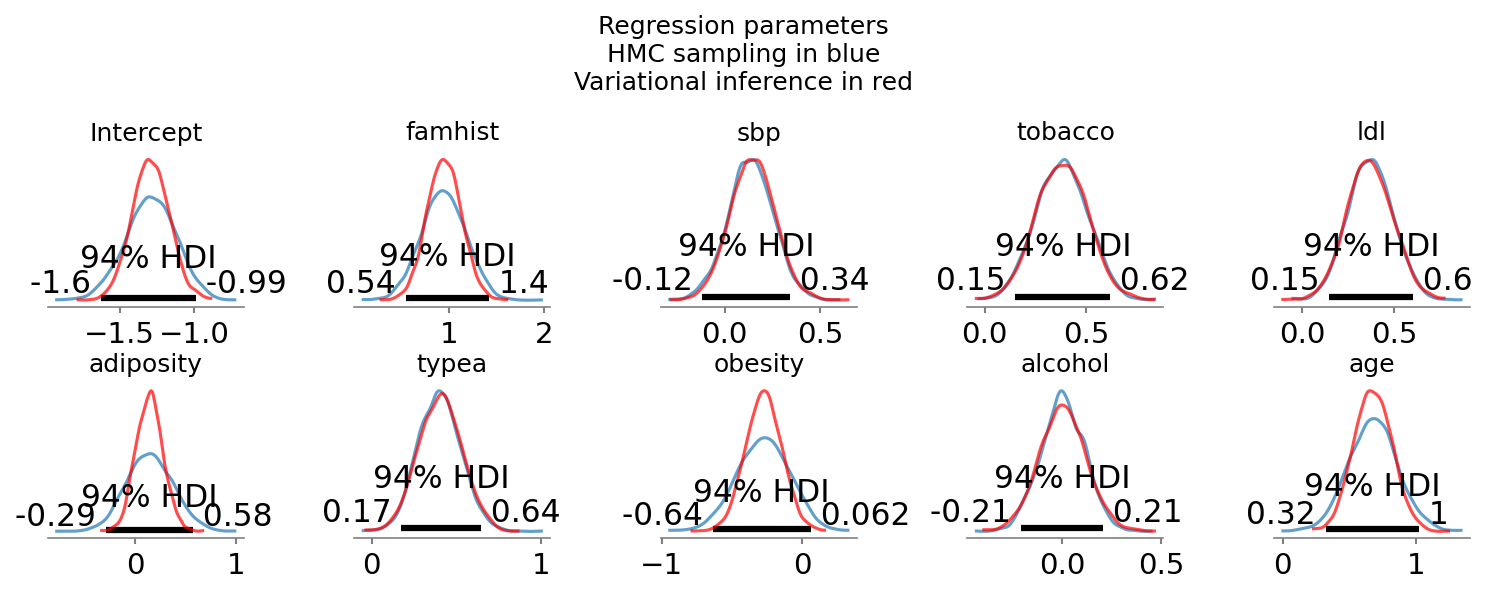

In [20]:
burnin = 100
sample_intercept = trace_hw3['Intercept'][burnin:]
sample_betas = [trace_hw3['famhist'][burnin:]] + [trace_hw3['sbp'][burnin:]] +\
    [trace_hw3['tobacco'][burnin:]] + [trace_hw3['ldl'][burnin:]] +\
    [trace_hw3['adiposity'][burnin:]] + [trace_hw3['typea'][burnin:]] +\
    [trace_hw3['obesity'][burnin:]] + [trace_hw3['alcohol'][burnin:]] +\
    [trace_hw3['age'][burnin:]]
advi_intercept = advi_trace['Intercept'][burnin:]
advi_betas = [advi_trace['famhist'][burnin:]] + [advi_trace['sbp'][burnin:]] +\
    [advi_trace['tobacco'][burnin:]] + [advi_trace['ldl'][burnin:]] +\
    [advi_trace['adiposity'][burnin:]] + [advi_trace['typea'][burnin:]] +\
    [advi_trace['obesity'][burnin:]] + [advi_trace['alcohol'][burnin:]] +\
    [advi_trace['age'][burnin:]]

k = 9
predictors = ['Intercept', 'famhist', 'sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']

fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (10, 4), dpi = 150)

for ax, estimate_sampling, estimate_advi, title, xlabel in zip(axes.ravel(),
                                                               [sample_intercept] + [sample_betas[i] for i in range(k)],
                                                               [advi_intercept] + [advi_betas[i] for i in range(k)],
                                                               predictors,
                                                               predictors):
    
    #pm.plot_posterior(estimate_sampling, ax=ax, point_estimate=None, credible_interval=None, alpha=0.7)
    pm.plot_posterior(estimate_sampling, ax=ax, point_estimate=None,  alpha=0.7)
    pm.plot_posterior(estimate_advi, ax=ax, color='red', point_estimate=None, hdi_prob= 'hide', alpha=0.7)
    
    ax.set_title(title, fontsize=12)

    #ax.set_xlabel(xlabel, fontsize=12)

plt.suptitle("Regression parameters\nHMC sampling in blue\nVariational inference in red")
plt.tight_layout()
plt.subplots_adjust(top=0.75)
plt.show()

We can see that the ADVI variational approach works pretty well for the variables that does not have 0 in the 94% confidence interval. For the variables that are not statistically significant, two methods should very different posterior distribution.

### Problem 5

(20) With the data set bangladesh.csv, develop a partial-pooled model for
all districts to predict contraception usage. Do not use any other predictor
variable besides district. Use both sampling and variational inference with
ADVI optimization to develop estimates of the proportions of women using
contraception in each district. Plot each of these estimates by district.
Compare and discuss your results.

Optionally, you can choose to use your hierarchical results from HW 3 and compare them to hierarchical results using variational approximation. This means developing a hierarchical model of the form: beta0[district] + beta1[district]*age and then estimating the distributions for the parameters using variational methods since you have already done this using sampling in HW 3. If you do this, then just compare the beta0[distict] distributions between the two techniques using plots like the ones I showed in class and are in the code snippet I uploaded. You do not have to compare the beta[1] distributions.

In [21]:
data = pd.read_csv('bangladesh.csv')
# data preprocessing
data.district = data.district.astype(str).map(str.strip)
mn_district = data.district.unique()
districts = len(mn_district)
district_lookup = dict(zip(mn_district, range(len(mn_district))))
district = data['district'] = data.district.replace(district_lookup).values

data = data.rename(columns={'use.contraception': 'use_contraception',
                        'age.centered': 'age_centered'})

use = data.use_contraception
age = data.age_centered

In [22]:
# Hierarchical Model
with pm.Model() as varying_intercept_slope:

    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    
    mu_b = pm.Normal('mu_b', mu=0., sd=1e5)
    sigma_b = pm.Exponential("sigma_b", .5)

    # Random intercepts
    beta0 = pm.Normal('beta0', mu=mu_a, sd=sigma_a, shape=districts)
    # Random slopes
    beta1 = pm.Normal('beta1', mu=mu_b, sd=sigma_b, shape=districts)

    # Model error
    sigma = pm.HalfCauchy('sigma', 5)

    y_hat = beta0[district] +  beta1[district] * age
    
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma, observed=use)
    
    trace = pm.sample(1000, tune = 1000, init = 'adapt_diag', target_accept=0.99, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta1, beta0, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9448901611394072, but should be close to 0.99. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9713917311374619, but should be close to 0.99. Try to increase the number of tuning steps.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9187733649670382, but should be close to 0.99. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters

In [23]:
with pm.Model() as advi_var_inf_hw5:
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=1e5)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    
    mu_b = pm.Normal('mu_b', mu=0., sd=1e5)
    sigma_b = pm.Exponential("sigma_b", .5)

    # Random intercepts
    beta0 = pm.Normal('beta0', mu=mu_a, sd=sigma_a, shape=districts)
    # Random slopes
    beta1 = pm.Normal('beta1', mu=mu_b, sd=sigma_b, shape=districts)

    # Model error
    sigma = pm.HalfCauchy('sigma', 5)

    y_hat = beta0[district] +  beta1[district] * age
    
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma, observed=use)
    
    trace_hw5 = pm.fit(40000, method = 'advi', random_seed = 666)

Finished [100%]: Average Loss = 1,386.8


In [24]:
PPC_SAMPLES = 4000
advi_trace5 = trace_hw5.sample(PPC_SAMPLES)

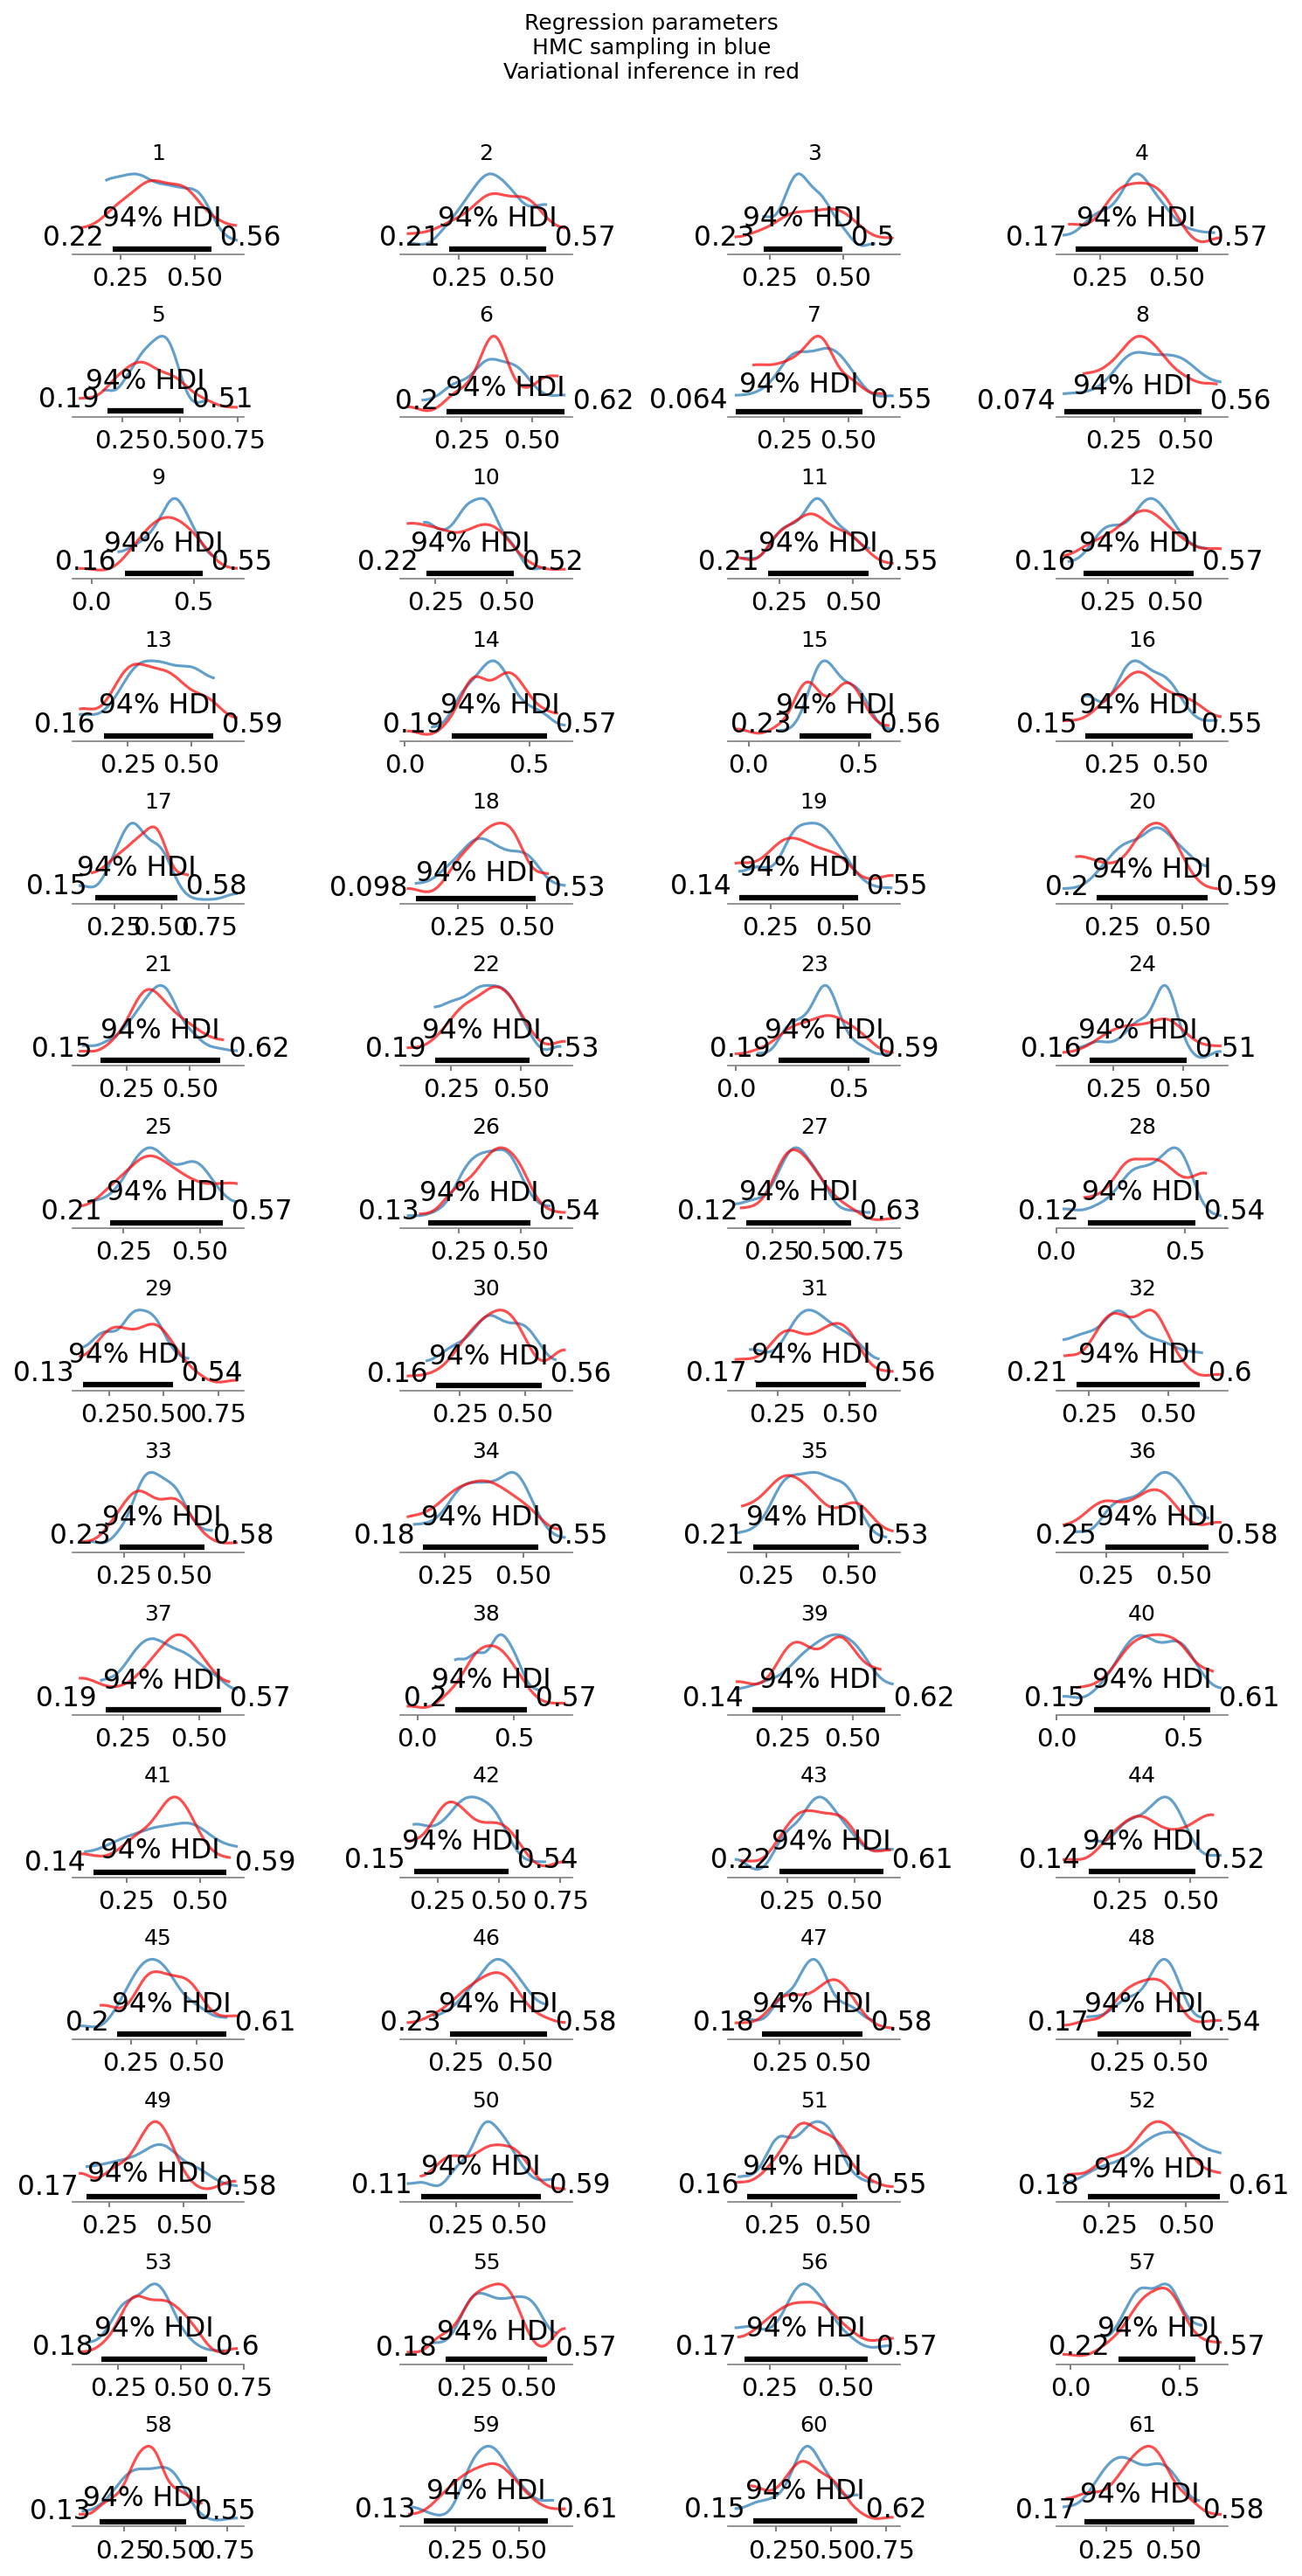

In [25]:
burnin = 100
sample_intercept = trace['beta0'][burnin:]

advi_intercept = advi_trace5['beta0'][burnin:]

k = districts

fig, axes = plt.subplots(nrows = 15, ncols = 4, figsize = (10, 20), dpi = 150)

for ax, estimate_sampling, estimate_advi, title, xlabel in zip(axes.ravel(),
                                                               [sample_intercept[i] for i in range(k)],
                                                               [advi_intercept[i] for i in range(k)],
                                                               mn_district,
                                                               mn_district):
    
    #pm.plot_posterior(estimate_sampling, ax=ax, point_estimate=None, credible_interval=None, alpha=0.7)
    pm.plot_posterior(estimate_sampling, ax=ax, point_estimate=None,  alpha=0.7)
    pm.plot_posterior(estimate_advi, ax=ax, color='red', point_estimate=None, hdi_prob= 'hide', alpha=0.7)
    
    ax.set_title(title, fontsize=12)

    # ax.set_xlabel(xlabel, fontsize=10)

plt.suptitle("Regression parameters\nHMC sampling in blue\nVariational inference in red")
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()